In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv('../data/diamonds_preprocessed.csv')
df = df.sample(frac = 1)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
4876,0.23,3,8,3,62.4,56.0,468,3.93,3.98,2.46
19042,0.60,5,7,5,61.4,58.0,1749,5.44,5.47,3.35
6340,1.00,3,5,3,63.8,58.0,6389,6.31,6.35,4.04
8856,0.70,5,4,5,61.5,56.0,2536,5.74,5.71,3.52
36469,0.55,5,7,5,60.6,56.0,1551,5.30,5.33,3.22


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data = df.drop(columns = ['price', 'cut', 'color', 'clarity', 'depth', 'table'], axis = 1)
data = scaler.fit_transform(data)

In [34]:
#import joblib
#joblib.dump(scaler, '../models/scaler_model.joblib')

['../models/scaler_model.joblib']

In [48]:
data = pd.DataFrame(data, columns = df.drop(columns = ['price', 'cut', 'color', 'clarity', 'depth', 'table'], axis = 1).columns.tolist())
data.head()

,carat,x,y,z
0,0.002148,0.040735,-0.006983,0.315721
1,-0.187340,-0.075278,-0.059304,0.012569
2,-0.187340,-0.119899,-0.059304,0.041441
3,-0.987401,-1.137244,-1.149317,-1.214473
4,0.444287,0.540483,0.542384,0.691051


Determining the best number of clusters

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

range_n_clusters = range(2, 11)  # Testing between 2 to 10 clusters

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

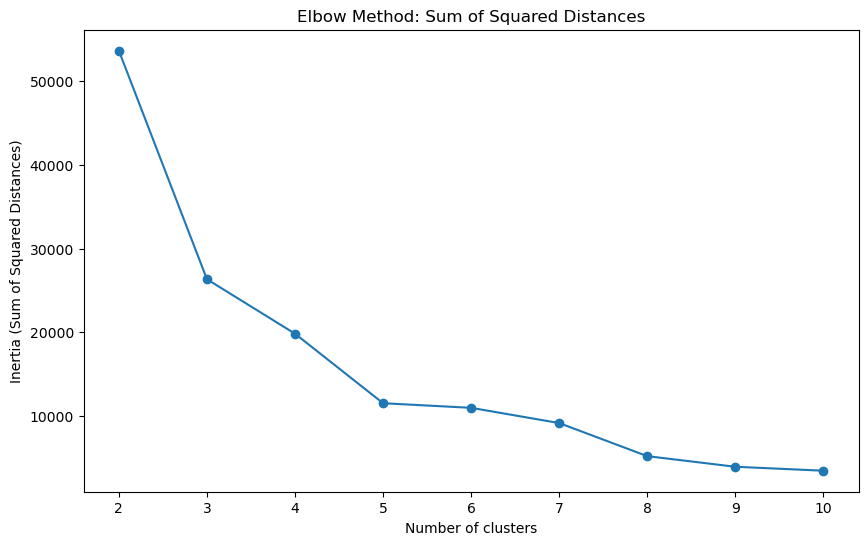

In [51]:
# 1. Elbow Method (Sum of Squared Distances)
inertia = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize = (10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method: Sum of Squared Distances')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.show()

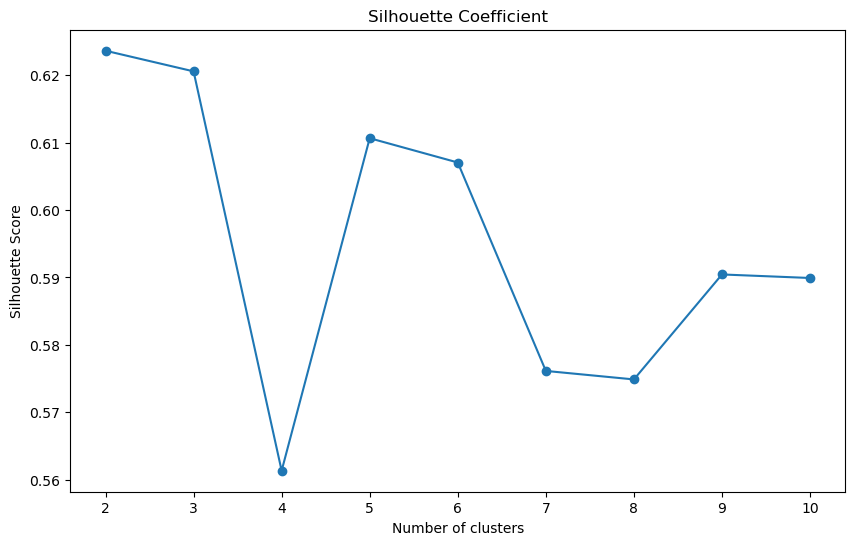

In [52]:
# 2. Silhouette Coefficient

sil_scores = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
    kmeans.fit(data)
    sil_scores.append(silhouette_score(data, kmeans.labels_))

plt.figure(figsize = (10, 6))
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.title('Silhouette Coefficient')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [53]:
# 3. Knee Locator for Elbow Method
# Using the kneedle algorithm to find the "elbow"
kneedle = KneeLocator(range_n_clusters, inertia, curve = 'convex', direction = 'decreasing')

# Print the optimal number of clusters
print(f'Optimal number of clusters according to Knee Locator: {kneedle.elbow}')

Optimal number of clusters according to Knee Locator: 5


INSIGHT : Outcome of potential number of clusters is inconclusive. Grid search wil be applied with range from 2 to 5 clusters.

# Defining functions

In [54]:
from sklearn.cluster import KMeans

def clusters(data : pd.DataFrame, n_clusters : int) -> pd.DataFrame :
    
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
    kmeans.fit(data)

    data['cluster'] = kmeans.labels_

    return data['cluster'], kmeans

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR

def models(X, y) :

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = pd.DataFrame(X_train, columns = X.columns.tolist())
    X_test = pd.DataFrame(X_test, columns = X.columns.tolist())

    index = [
        'Linear',
        'Elastic Net',
        'Random Forest',
        'XGBoost',
        'LightGBM',
        'CatBoost',
        'SVM'
    ]

    rmse = []
    mae = []

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_y_pred = lr.predict(X_test)
    lr_rmse = root_mean_squared_error(y_test, lr_y_pred)
    lr_mae = mean_absolute_error(y_test, lr_y_pred)
    rmse.append(lr_rmse)
    mae.append(lr_mae)

    en = ElasticNet(alpha = 0.05, l1_ratio = 0.95, random_state = 42)
    en.fit(X_train, y_train)
    en_y_pred = en.predict(X_test)
    en_rmse = root_mean_squared_error(y_test, en_y_pred)
    en_mae = mean_absolute_error(y_test, en_y_pred)
    rmse.append(en_rmse)
    mae.append(en_mae)

    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
    rf.fit(X_train, y_train)
    rf_y_pred = rf.predict(X_test)
    rf_rmse = root_mean_squared_error(y_test, rf_y_pred)
    rf_mae = mean_absolute_error(y_test, rf_y_pred)
    rmse.append(rf_rmse)
    mae.append(rf_mae)

    xgb = XGBRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 42)
    xgb.fit(X_train, y_train)
    xgb_y_pred = xgb.predict(X_test)
    xgb_rmse = root_mean_squared_error(y_test, xgb_y_pred)
    xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
    rmse.append(xgb_rmse)
    mae.append(xgb_mae)

    lgbm = LGBMRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 42, verbose = -1)
    lgbm.fit(X_train, y_train)
    lgbm_y_pred = lgbm.predict(X_test)
    lgbm_rmse = root_mean_squared_error(y_test, lgbm_y_pred)
    lgbm_mae = mean_absolute_error(y_test, lgbm_y_pred)
    rmse.append(lgbm_rmse)
    mae.append(lgbm_mae)

    catboost = CatBoostRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 42, verbose = 0, allow_writing_files = False)
    catboost.fit(X_train, y_train)
    cat_y_pred = catboost.predict(X_test)
    cat_rmse = root_mean_squared_error(y_test, cat_y_pred)
    cat_mae = mean_absolute_error(y_test, cat_y_pred)
    rmse.append(cat_rmse)
    mae.append(cat_mae)

    svr = SVR(kernel = 'rbf', C = 1.0, epsilon = 0.1)
    svr.fit(X_train, y_train)
    svm_y_pred = svr.predict(X_test)
    svm_rmse = root_mean_squared_error(y_test, svm_y_pred)
    svm_mae = mean_absolute_error(y_test, svm_y_pred)
    rmse.append(svm_rmse)
    mae.append(svm_mae)

    metrics = pd.DataFrame({
        'METHOD': index,
        'RMSE': np.round(rmse, 2),
        'MAE': np.round(mae, 2)
    })

    metrics.set_index('METHOD', inplace = True)
    return metrics, y_test.mean()

# k-Means : 2 clusters analysis

In [57]:
clusters2 = df.copy()
clusters2['cluster'], model_2 = clusters(data, 2)
clusters2.groupby('cluster')['price'].mean()

cluster
0    3934.508433
1    3946.174654
Name: price, dtype: float64

In [58]:
clusters2['cluster'].value_counts()

cluster
0    25911
1    19072
Name: count, dtype: int64

In [59]:
c2_c0 = clusters2.query('cluster == 0')
c2_c1 = clusters2.query('cluster == 1')

In [60]:
X_c2_c0 = c2_c0.drop(columns = ['price', 'cluster'], axis = 1)
y_c2_c0 = c2_c0['price']

stats_c2_c0, c2_c0_price_mean = models(X_c2_c0, y_c2_c0)
stats_c2_c0['RMSE to mean'] = stats_c2_c0['RMSE'].apply(lambda x: x / c2_c0_price_mean)
stats_c2_c0

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1393.54,871.93,0.355302
Elastic Net,1399.53,887.64,0.356829
Random Forest,1170.65,642.01,0.298473
XGBoost,1158.25,637.64,0.295312
LightGBM,1149.39,635.60,0.293053
CatBoost,1159.00,653.90,0.295503
SVM,3189.00,1617.33,0.813079


In [61]:
X_c2_c1 = c2_c1.drop(columns = ['price', 'cluster'], axis = 1)
y_c2_c1 = c2_c1['price']

stats_c2_c1, c2_c1_price_mean = models(X_c2_c1, y_c2_c1)
stats_c2_c1['RMSE to mean'] = stats_c2_c1['RMSE'].apply(lambda x: x / c2_c1_price_mean)
stats_c2_c1

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1417.26,882.72,0.351975
Elastic Net,1417.41,894.56,0.352012
Random Forest,1236.25,675.44,0.307021
XGBoost,1202.32,654.63,0.298595
LightGBM,1206.94,660.54,0.299742
CatBoost,1193.86,666.83,0.296494
SVM,3392.56,1778.09,0.842538


# k-Means : 3 clusters analysis

In [62]:
clusters3 = df.copy()
clusters3['cluster'], model_3 = clusters(data, 3)
clusters3.groupby('cluster')['price'].mean()

cluster
0    3923.412549
1    3963.811314
2    3946.410999
Name: price, dtype: float64

In [63]:
clusters3['cluster'].value_counts()

cluster
2    20820
0    18153
1     6010
Name: count, dtype: int64

In [64]:
c3_c0 = clusters3.query('cluster == 0')
c3_c1 = clusters3.query('cluster == 1')
c3_c2 = clusters3.query('cluster == 2')

In [65]:
X_c3_c0 = c3_c0.drop(columns = ['price', 'cluster'], axis = 1)
y_c3_c0 = c3_c0['price']

stats_c3_c0, c3_c0_price_mean = models(X_c3_c0, y_c3_c0)
stats_c3_c0['RMSE to mean'] = stats_c3_c0['RMSE'].apply(lambda x: x / c3_c0_price_mean)
stats_c3_c0

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1384.39,864.47,0.358678
Elastic Net,1389.37,880.55,0.359968
Random Forest,1163.27,639.83,0.301388
XGBoost,1142.65,627.39,0.296046
LightGBM,1144.08,631.55,0.296416
CatBoost,1136.31,638.28,0.294403
SVM,3280.00,1709.32,0.849806


In [66]:
X_c3_c1 = c3_c1.drop(columns = ['price', 'cluster'], axis = 1)
y_c3_c1 = c3_c1['price']

stats_c3_c1, c3_c1_price_mean = models(X_c3_c1, y_c3_c1)
stats_c3_c1['RMSE to mean'] = stats_c3_c1['RMSE'].apply(lambda x: x / c3_c1_price_mean)
stats_c3_c1

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1340.64,852.86,0.348991
Elastic Net,1362.21,874.74,0.354606
Random Forest,1235.37,664.06,0.321588
XGBoost,1250.60,669.14,0.325552
LightGBM,1256.87,665.06,0.327184
CatBoost,1190.56,648.68,0.309923
SVM,3792.42,2214.95,0.987231


In [67]:
X_c3_c2 = c3_c2.drop(columns = ['price', 'cluster'], axis = 1)
y_c3_c2 = c3_c2['price']

stats_c3_c2, c3_c2_price_mean = models(X_c3_c2, y_c3_c2)
stats_c3_c2['RMSE to mean'] = stats_c3_c2['RMSE'].apply(lambda x: x / c3_c2_price_mean)
stats_c3_c2

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1405.49,887.62,0.352894
Elastic Net,1413.18,903.70,0.354825
Random Forest,1168.92,655.41,0.293496
XGBoost,1147.49,646.72,0.288115
LightGBM,1137.79,644.48,0.285680
CatBoost,1166.14,668.24,0.292798
SVM,3325.02,1720.08,0.834855


# k-Means : 4 clusters analysis

In [69]:
clusters4 = df.copy()
clusters4['cluster'], model_4 = clusters(data, 4)
clusters4.groupby('cluster')['price'].mean()

cluster
0    3929.349115
1    3946.410999
2    3918.666949
3    3966.463308
Name: price, dtype: float64

In [70]:
clusters4['cluster'].value_counts()

cluster
1    20820
2    10632
0     7794
3     5737
Name: count, dtype: int64

In [71]:
c4_c0 = clusters4.query('cluster == 0')
c4_c1 = clusters4.query('cluster == 1')
c4_c2 = clusters4.query('cluster == 2')
c4_c3 = clusters4.query('cluster == 3')

In [72]:
X_c4_c0 = c4_c0.drop(columns = ['price', 'cluster'], axis = 1)
y_c4_c0 = c4_c0['price']

stats_c4_c0, c4_c0_price_mean = models(X_c4_c0, y_c4_c0)
stats_c4_c0['RMSE to mean'] = stats_c4_c0['RMSE'].apply(lambda x: x / c4_c0_price_mean)
stats_c4_c0

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1364.07,861.99,0.344098
Elastic Net,1369.03,878.36,0.345349
Random Forest,1211.28,665.47,0.305555
XGBoost,1190.04,651.00,0.300197
LightGBM,1187.77,657.39,0.299625
CatBoost,1149.82,652.22,0.290052
SVM,3760.08,2219.35,0.948511


In [73]:
X_c4_c1 = c4_c1.drop(columns = ['price', 'cluster'], axis = 1)
y_c4_c1 = c4_c1['price']

stats_c4_c1, c4_c1_price_mean = models(X_c4_c1, y_c4_c1)
stats_c4_c1['RMSE to mean'] = stats_c4_c1['RMSE'].apply(lambda x: x / c4_c1_price_mean)
stats_c4_c1

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1405.49,887.62,0.352894
Elastic Net,1413.18,903.70,0.354825
Random Forest,1168.92,655.41,0.293496
XGBoost,1147.49,646.72,0.288115
LightGBM,1137.79,644.48,0.285680
CatBoost,1166.14,668.24,0.292798
SVM,3325.02,1720.08,0.834855


In [74]:
X_c4_c2 = c4_c2.drop(columns = ['price', 'cluster'], axis = 1)
y_c4_c2 = c4_c2['price']

stats_c4_c2, c4_c2_price_mean = models(X_c4_c2, y_c4_c2)
stats_c4_c2['RMSE to mean'] = stats_c4_c2['RMSE'].apply(lambda x: x / c4_c2_price_mean)
stats_c4_c2

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1396.51,856.94,0.359087
Elastic Net,1407.63,871.57,0.361947
Random Forest,1181.74,658.69,0.303863
XGBoost,1143.66,637.05,0.294071
LightGBM,1150.39,644.29,0.295802
CatBoost,1141.83,649.03,0.293601
SVM,3593.21,2007.43,0.923929


In [75]:
X_c4_c3 = c4_c3.drop(columns = ['price', 'cluster'], axis = 1)
y_c4_c3 = c4_c3['price']

stats_c4_c3, c4_c3_price_mean = models(X_c4_c3, y_c4_c3)
stats_c4_c3['RMSE to mean'] = stats_c4_c3['RMSE'].apply(lambda x: x / c4_c3_price_mean)
stats_c4_c3

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1489.92,931.52,0.362234
Elastic Net,1441.62,930.29,0.350491
Random Forest,1294.49,724.98,0.314720
XGBoost,1347.37,733.01,0.327577
LightGBM,1337.30,745.58,0.325128
CatBoost,1254.45,712.12,0.304986
SVM,4024.92,2424.34,0.978551


# k-Means : 5 clusters analysis

In [76]:
clusters5 = df.copy()
clusters5['cluster'], model_5 = clusters(data, 5)
clusters5.groupby('cluster')['price'].mean()

cluster
0    3929.349115
1    3918.666949
2    3942.998024
3    3966.463308
4    3952.930668
Name: price, dtype: float64

In [77]:
clusters5['cluster'].value_counts()

cluster
2    13666
1    10632
0     7794
4     7154
3     5737
Name: count, dtype: int64

In [78]:
c5_c0 = clusters5.query('cluster == 0')
c5_c1 = clusters5.query('cluster == 1')
c5_c2 = clusters5.query('cluster == 2')
c5_c3 = clusters5.query('cluster == 3')
c5_c4 = clusters5.query('cluster == 4')

In [79]:
X_c5_c0 = c5_c0.drop(columns = ['price', 'cluster'], axis = 1)
y_c5_c0 = c5_c0['price']

stats_c5_c0, c5_c0_price_mean = models(X_c5_c0, y_c5_c0)
stats_c5_c0['RMSE to mean'] = stats_c5_c0['RMSE'].apply(lambda x: x / c5_c0_price_mean)
stats_c5_c0

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1364.07,861.99,0.344098
Elastic Net,1369.03,878.36,0.345349
Random Forest,1211.28,665.47,0.305555
XGBoost,1190.04,651.00,0.300197
LightGBM,1187.77,657.39,0.299625
CatBoost,1149.82,652.22,0.290052
SVM,3760.08,2219.35,0.948511


In [80]:
X_c5_c1 = c5_c1.drop(columns = ['price', 'cluster'], axis = 1)
y_c5_c1 = c5_c1['price']

stats_c5_c1, c5_c1_price_mean = models(X_c5_c1, y_c5_c1)
stats_c5_c1['RMSE to mean'] = stats_c5_c1['RMSE'].apply(lambda x: x / c5_c1_price_mean)
stats_c5_c1

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1396.51,856.94,0.359087
Elastic Net,1407.63,871.57,0.361947
Random Forest,1181.74,658.69,0.303863
XGBoost,1143.66,637.05,0.294071
LightGBM,1150.39,644.29,0.295802
CatBoost,1141.83,649.03,0.293601
SVM,3593.21,2007.43,0.923929


In [82]:
X_c5_c2 = c5_c2.drop(columns = ['price', 'cluster'], axis = 1)
y_c5_c2 = c5_c2['price']

stats_c5_c2, c5_c2_price_mean = models(X_c5_c2, y_c5_c2)
stats_c5_c2['RMSE to mean'] = stats_c5_c2['RMSE'].apply(lambda x: x / c5_c2_price_mean)
stats_c5_c2

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1420.08,872.94,0.367847
Elastic Net,1415.15,886.33,0.366570
Random Forest,1109.11,636.18,0.287296
XGBoost,1090.58,627.48,0.282496
LightGBM,1087.76,624.05,0.281765
CatBoost,1081.13,631.99,0.280048
SVM,3372.52,1822.49,0.873593


In [83]:
X_c5_c3 = c5_c3.drop(columns = ['price', 'cluster'], axis = 1)
y_c5_c3 = c5_c3['price']

stats_c5_c3, c5_c3_price_mean = models(X_c5_c3, y_c5_c3)
stats_c5_c3['RMSE to mean'] = stats_c5_c3['RMSE'].apply(lambda x: x / c5_c3_price_mean)
stats_c5_c3

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1489.92,931.52,0.362234
Elastic Net,1441.62,930.29,0.350491
Random Forest,1294.49,724.98,0.314720
XGBoost,1347.37,733.01,0.327577
LightGBM,1337.30,745.58,0.325128
CatBoost,1254.45,712.12,0.304986
SVM,4024.92,2424.34,0.978551


In [84]:
X_c5_c4 = c5_c4.drop(columns = ['price', 'cluster'], axis = 1)
y_c5_c4 = c5_c4['price']

stats_c5_c4, c5_c4_price_mean = models(X_c5_c4, y_c5_c4)
stats_c5_c4['RMSE to mean'] = stats_c5_c4['RMSE'].apply(lambda x: x / c5_c4_price_mean)
stats_c5_c4

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1419.29,909.67,0.357135
Elastic Net,1436.02,922.17,0.361345
Random Forest,1227.90,673.11,0.308976
XGBoost,1240.09,688.87,0.312043
LightGBM,1212.92,675.61,0.305207
CatBoost,1189.07,671.05,0.299205
SVM,3817.43,2267.76,0.960579


INSIGHT : Aborting the grid search process. Clustering according to carats, x, y, z didn't result with expected outcome. Let's try sth simpler - manual clustering according to price only based od price boxplot and histogram.

# Manual clustering based on price distribution

In [9]:
df = pd.read_csv('../data/diamonds_preprocessed.csv')
df = df.sample(frac = 1)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
10941,0.31,3,8,3,63.5,56.0,732,4.31,4.29,2.73
6172,1.66,3,3,3,63.0,57.0,8901,7.45,7.50,4.71
8908,0.51,2,5,2,63.3,58.0,1800,5.04,5.07,3.20
76,0.30,5,5,5,62.0,54.0,776,4.35,4.30,2.68
39728,0.35,4,7,4,60.8,60.0,788,4.57,4.51,2.76


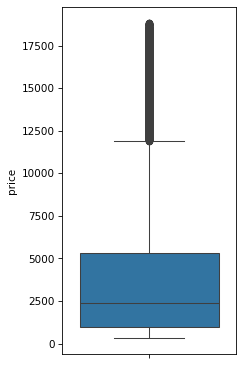

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (3, 6), dpi = 75)
sns.boxplot(data = df['price'])
plt.show();

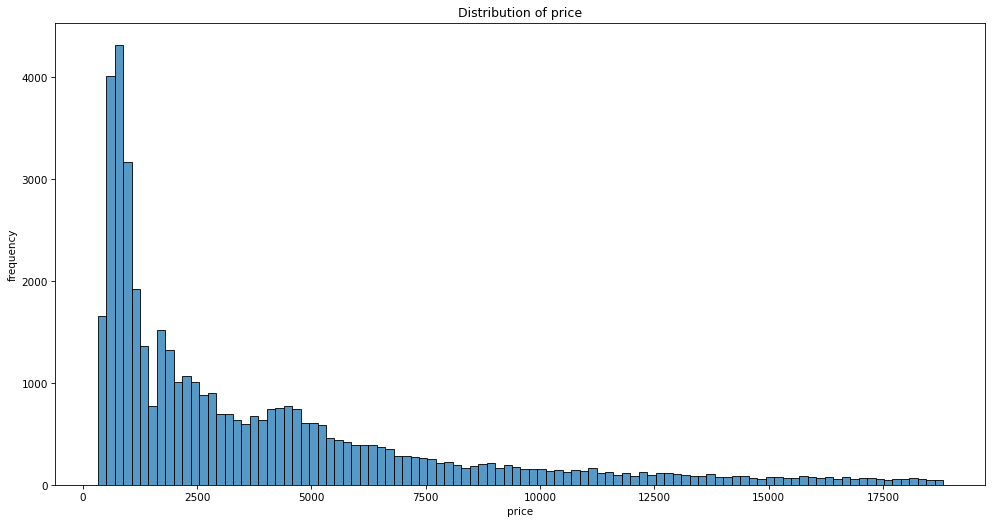

In [147]:
plt.figure(figsize = (16, 8), dpi = 75)
sns.histplot(df['price'], bins = 100)
plt.title(f'Distribution of price')
plt.xlabel('price')
plt.ylabel('frequency')
plt.show();

In [151]:
len(df.query('price < 1000')), len(df.query('price >= 1000 & price < 2500')), len(df.query('price >= 2500 & price < 5000')), len(df.query('price >= 5000 & price < 12000')), len(df.query('price >= 12000'))

(12103, 10833, 9729, 9411, 2907)

In [11]:
cluster_0 = df.query('price < 1000').copy()
cluster_1 = df.query('price >= 1000 & price < 2500').copy()
cluster_2 = df.query('price >= 2500 & price < 5000').copy()
cluster_3 = df.query('price >= 5000 & price < 12000').copy()
cluster_4 = df.query('price >= 12000').copy()

In [153]:
X_cluster_0 = cluster_0.drop(columns = ['price'], axis = 1)
y_cluster_0 = cluster_0['price']

stats_cluster_0, cluster_0_price_mean = models(X_cluster_0, y_cluster_0)
stats_cluster_0['RMSE to mean'] = stats_cluster_0['RMSE'].apply(lambda x: x / cluster_0_price_mean)
stats_cluster_0

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,128.85,100.84,0.181772
Elastic Net,122.45,100.26,0.172743
Random Forest,115.29,91.66,0.162642
XGBoost,110.72,89.48,0.156195
LightGBM,110.14,89.01,0.155377
CatBoost,113.71,92.24,0.160414
SVM,128.18,105.46,0.180827


In [154]:
X_cluster_1 = cluster_1.drop(columns = ['price'], axis = 1)
y_cluster_1 = cluster_1['price']

stats_cluster_1, cluster_1_price_mean = models(X_cluster_1, y_cluster_1)
stats_cluster_1['RMSE to mean'] = stats_cluster_1['RMSE'].apply(lambda x: x / cluster_1_price_mean)
stats_cluster_1

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,266.84,207.66,0.161115
Elastic Net,264.35,207.09,0.159612
Random Forest,247.60,183.10,0.149498
XGBoost,240.66,177.77,0.145308
LightGBM,241.16,178.34,0.145610
CatBoost,243.35,180.43,0.146932
SVM,281.62,225.08,0.170039


In [155]:
X_cluster_2 = cluster_2.drop(columns = ['price'], axis = 1)
y_cluster_2 = cluster_2['price']

stats_cluster_2, cluster_2_price_mean = models(X_cluster_2, y_cluster_2)
stats_cluster_2['RMSE to mean'] = stats_cluster_2['RMSE'].apply(lambda x: x / cluster_2_price_mean)
stats_cluster_2

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,502.01,387.91,0.135364
Elastic Net,498.67,387.97,0.134464
Random Forest,455.23,352.63,0.122750
XGBoost,444.95,345.66,0.119978
LightGBM,446.24,346.37,0.120326
CatBoost,443.78,346.86,0.119663
SVM,520.58,434.64,0.140371


In [156]:
X_cluster_3 = cluster_3.drop(columns = ['price'], axis = 1)
y_cluster_3 = cluster_3['price']

stats_cluster_3, cluster_3_price_mean = models(X_cluster_3, y_cluster_3)
stats_cluster_3['RMSE to mean'] = stats_cluster_3['RMSE'].apply(lambda x: x / cluster_3_price_mean)
stats_cluster_3

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,1550.78,1240.43,0.206339
Elastic Net,1552.83,1241.51,0.206611
Random Forest,1424.86,1085.76,0.189584
XGBoost,1393.90,1063.41,0.185465
LightGBM,1390.62,1067.29,0.185028
CatBoost,1406.88,1083.76,0.187192
SVM,1797.91,1460.12,0.239220


In [157]:
X_cluster_4 = cluster_4.drop(columns = ['price'], axis = 1)
y_cluster_4 = cluster_4['price']

stats_cluster_4, cluster_4_price_mean = models(X_cluster_4, y_cluster_4)
stats_cluster_4['RMSE to mean'] = stats_cluster_4['RMSE'].apply(lambda x: x / cluster_4_price_mean)
stats_cluster_4

,RMSE,MAE,RMSE to mean
METHOD,,,
Linear,14987.03,2092.23,0.996207
Elastic Net,8832.35,1799.98,0.587098
Random Forest,1650.16,1340.89,0.109688
XGBoost,1662.43,1348.80,0.110504
LightGBM,1650.06,1340.87,0.109682
CatBoost,1641.38,1347.16,0.109105
SVM,1926.32,1641.79,0.128045


INSIGHT :

In [12]:
cluster_0['cluster'] = 0
cluster_1['cluster'] = 1
cluster_2['cluster'] = 2
cluster_3['cluster'] = 3
cluster_4['cluster'] = 4

In [13]:
df_clusters = pd.concat([cluster_0, cluster_1, cluster_2, cluster_3, cluster_4], ignore_index = True).sample(frac = 1)
df_clusters.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z,cluster
30253,0.56,3,8,3,62.0,56.0,2866,5.25,5.30,3.27,2
14053,0.50,4,7,4,61.4,62.0,1238,5.10,5.07,3.12,1
40288,1.50,2,4,2,64.3,60.0,9768,7.14,7.23,4.62,3
31981,0.70,5,5,5,61.9,58.0,2567,5.66,5.69,3.51,2
32417,0.90,3,2,3,62.6,55.0,3102,6.11,6.13,3.83,2
17345,0.50,3,6,3,63.1,60.0,1020,5.00,5.04,3.17,1
18076,0.43,4,3,4,61.2,58.0,1129,4.88,4.83,2.97,1
34574,1.12,5,6,5,61.9,55.0,5046,6.68,6.72,4.15,3
9488,0.30,5,4,5,60.7,57.0,473,4.33,4.37,2.64,0
25782,0.95,1,5,1,66.7,56.0,2841,6.16,6.03,4.06,2


In [165]:
cluster_0.to_csv('../data/clusters/cluster_0.csv')
cluster_1.to_csv('../data/clusters/cluster_1.csv')
cluster_2.to_csv('../data/clusters/cluster_2.csv')
cluster_3.to_csv('../data/clusters/cluster_3.csv')
cluster_4.to_csv('../data/clusters/cluster_4.csv')

# Classifying clusters

In [7]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [36]:
X_clusters = df_clusters.drop(columns = ['price', 'cluster'], axis =1)
y_clusters = df_clusters['cluster']

In [170]:
X_clusters_train, X_clusters_test, y_clusters_train, y_clusters_test = train_test_split(X_clusters, y_clusters, test_size = 0.2, random_state = 42)

In [171]:
scaler = StandardScaler()

X_clusters_train = scaler.fit_transform(X_clusters_train)
X_clusters_test = scaler.transform(X_clusters_test)

X_clusters_train = pd.DataFrame(X_clusters_train, columns = X_clusters.columns.tolist())
X_clusters_test = pd.DataFrame(X_clusters_test, columns = X_clusters.columns.tolist())

Logistic Regression Classifier

In [173]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression for multi-class classification
clf_logreg = LogisticRegression(multi_class = 'auto', solver = 'lbfgs', max_iter = 1000)
clf_logreg.fit(X_clusters_train, y_clusters_train)

# Evaluate
accuracy = clf_logreg.score(X_clusters_test, y_clusters_test)
print("Logistic Regression accuracy:", accuracy)

# Predict buckets for new data
clf_logreg_preds = clf_logreg.predict(X_clusters_test)


Logistic Regression accuracy: 0.802267422474158


In [214]:
clf_logreg_proba = clf_logreg.predict_proba(X_clusters_test)
auc_score = roc_auc_score(y_clusters_test, clf_logreg_proba, multi_class = 'ovr')
print("Multi-class AUC (One-vs-Rest):", auc_score)

Multi-class AUC (One-vs-Rest): 0.9677094011401316


Confussion Matrix:


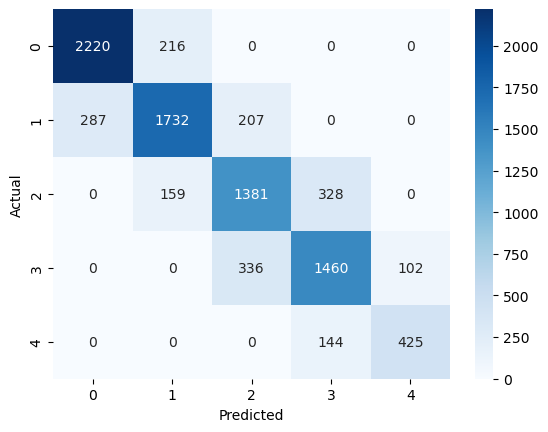

In [182]:
print('Confussion Matrix:')
sns.heatmap(confusion_matrix(y_clusters_test, clf_logreg_preds), annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();

In [176]:
report = classification_report(y_clusters_test, clf_logreg_preds)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2436
           1       0.82      0.78      0.80      2226
           2       0.72      0.74      0.73      1868
           3       0.76      0.77      0.76      1898
           4       0.81      0.75      0.78       569

    accuracy                           0.80      8997
   macro avg       0.80      0.79      0.79      8997
weighted avg       0.80      0.80      0.80      8997



In [25]:
X = df_clusters.drop(columns = ['price', 'cluster'], axis = 1)
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
30253,0.56,3,8,3,62.0,56.0,5.25,5.30,3.27
14053,0.50,4,7,4,61.4,62.0,5.10,5.07,3.12
40288,1.50,2,4,2,64.3,60.0,7.14,7.23,4.62
31981,0.70,5,5,5,61.9,58.0,5.66,5.69,3.51
32417,0.90,3,2,3,62.6,55.0,6.11,6.13,3.83


In [31]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2, interaction_only = True)  # 2nd-degree interactions
X_poly = poly.fit_transform(X)

In [32]:
df_X_poly = pd.DataFrame(X_poly)
df_X_poly.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,1.0,0.56,3.0,8.0,3.0,62.0,56.0,5.25,5.30,3.27,...,3472.0,325.500,328.600,202.740,294.00,296.80,183.12,27.8250,17.1675,17.3310
1,1.0,0.50,4.0,7.0,4.0,61.4,62.0,5.10,5.07,3.12,...,3806.8,313.140,311.298,191.568,316.20,314.34,193.44,25.8570,15.9120,15.8184
2,1.0,1.50,2.0,4.0,2.0,64.3,60.0,7.14,7.23,4.62,...,3858.0,459.102,464.889,297.066,428.40,433.80,277.20,51.6222,32.9868,33.4026
3,1.0,0.70,5.0,5.0,5.0,61.9,58.0,5.66,5.69,3.51,...,3590.2,350.354,352.211,217.269,328.28,330.02,203.58,32.2054,19.8666,19.9719
4,1.0,0.90,3.0,2.0,3.0,62.6,55.0,6.11,6.13,3.83,...,3443.0,382.486,383.738,239.758,336.05,337.15,210.65,37.4543,23.4013,23.4779


In [40]:
df_X_poly.columns = df_X_poly.columns.astype(str) 

X_combined = pd.concat([X, df_X_poly], axis = 1)
X_combined.head()

,carat,cut,color,clarity,depth,table,x,y,z,0,...,36,37,38,39,40,41,42,43,44,45
30253,0.56,3,8,3,62.0,56.0,5.25,5.30,3.27,1.0,...,3483.2,281.766,278.656,174.160,253.68,250.88,156.80,20.2944,12.6840,12.5440
14053,0.50,4,7,4,61.4,62.0,5.10,5.07,3.12,1.0,...,3538.0,286.700,289.750,175.680,272.60,275.50,167.04,22.3250,13.5360,13.6800
40288,1.50,2,4,2,64.3,60.0,7.14,7.23,4.62,1.0,...,3348.0,266.600,269.080,166.160,232.20,234.36,144.72,18.6620,11.5240,11.6312
31981,0.70,5,5,5,61.9,58.0,5.66,5.69,3.51,1.0,...,3485.8,393.655,391.852,236.193,379.90,378.16,227.94,42.7060,25.7415,25.6236
32417,0.90,3,2,3,62.6,55.0,6.11,6.13,3.83,1.0,...,3516.9,315.904,317.755,195.589,291.84,293.55,180.69,26.3680,16.2304,16.3255


In [41]:
from sklearn.model_selection import train_test_split
X_combined_train, X_combined_test, y_clusters_train, y_clusters_test = train_test_split(X_combined, y_clusters, test_size = 0.2, random_state = 42)

In [42]:
X_combined_train = scaler.fit_transform(X_combined_train)
X_combined_test = scaler.transform(X_combined_test)

X_combined_train = pd.DataFrame(X_combined_train, columns = X_combined.columns.tolist())
X_combined_test = pd.DataFrame(X_combined_test, columns = X_combined.columns.tolist())

Random Forest Classifier

In [185]:
from sklearn.ensemble import RandomForestClassifier

# Using the same X_train, X_test, y_train, y_test from above
clf_rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
clf_rf.fit(X_clusters_train, y_clusters_train)

accuracy_rf = clf_rf.score(X_clusters_test, y_clusters_test)
print("Random Forest accuracy:", accuracy_rf)

clf_rf_preds = clf_rf.predict(X_clusters_test)

Random Forest accuracy: 0.8126042014004669


In [215]:
clf_rf_proba = clf_rf.predict_proba(X_clusters_test)
auc_score = roc_auc_score(y_clusters_test, clf_rf_proba, multi_class = 'ovr')
print("Multi-class AUC (One-vs-Rest):", auc_score)

Multi-class AUC (One-vs-Rest): 0.9693137068313854


Confussion Matrix:


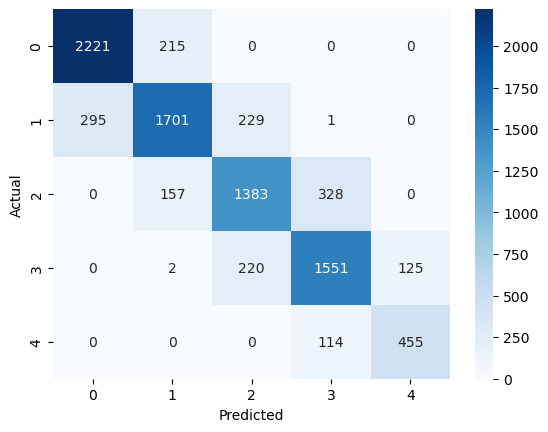

In [186]:
print('Confussion Matrix:')
sns.heatmap(confusion_matrix(y_clusters_test, clf_rf_preds), annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();

In [187]:
report = classification_report(y_clusters_test, clf_rf_preds)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      2436
           1       0.82      0.76      0.79      2226
           2       0.75      0.74      0.75      1868
           3       0.78      0.82      0.80      1898
           4       0.78      0.80      0.79       569

    accuracy                           0.81      8997
   macro avg       0.80      0.81      0.80      8997
weighted avg       0.81      0.81      0.81      8997



XGBoost Classifier

In [189]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(n_estimators = 100, random_state = 42, use_label_encoder = False)
clf_xgb.fit(X_clusters_train, y_clusters_train)

accuracy_xgb = clf_xgb.score(X_clusters_test, y_clusters_test)
print("XGBoost accuracy:", accuracy_xgb)

clf_xgb_preds = clf_xgb.predict(X_clusters_test)

XGBoost accuracy: 0.8172724241413805


In [216]:
clf_xgb_proba = clf_logreg.predict_proba(X_clusters_test)
auc_score = roc_auc_score(y_clusters_test, clf_xgb_proba, multi_class = 'ovr')
print("Multi-class AUC (One-vs-Rest):", auc_score)

Multi-class AUC (One-vs-Rest): 0.9677094011401316


Confussion Matrix:


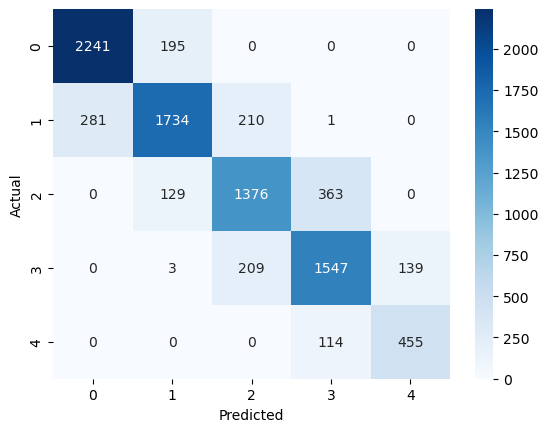

In [190]:
print('Confussion Matrix:')
sns.heatmap(confusion_matrix(y_clusters_test, clf_xgb_preds), annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();

In [191]:
report = classification_report(y_clusters_test, clf_xgb_preds)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2436
           1       0.84      0.78      0.81      2226
           2       0.77      0.74      0.75      1868
           3       0.76      0.82      0.79      1898
           4       0.77      0.80      0.78       569

    accuracy                           0.82      8997
   macro avg       0.81      0.81      0.81      8997
weighted avg       0.82      0.82      0.82      8997



LightGBM Classifier

In [200]:
from lightgbm import LGBMClassifier

# Create and fit LightGBM classifier
clf_lgbm = LGBMClassifier(n_estimators = 100, random_state = 42)
clf_lgbm.fit(X_clusters_train, y_clusters_train)

# Evaluate
accuracy_lgbm = clf_lgbm.score(X_clusters_test, y_clusters_test)
print("LightGBM accuracy:", accuracy_lgbm)

clf_lgbm_preds = clf_lgbm.predict(X_clusters_test)

LightGBM accuracy: 0.8187173502278537


In [217]:
clf_lgbm_proba = clf_logreg.predict_proba(X_clusters_test)
auc_score = roc_auc_score(y_clusters_test, clf_lgbm_proba, multi_class = 'ovr')
print("Multi-class AUC (One-vs-Rest):", auc_score)

Multi-class AUC (One-vs-Rest): 0.9677094011401316


Confussion Matrix:


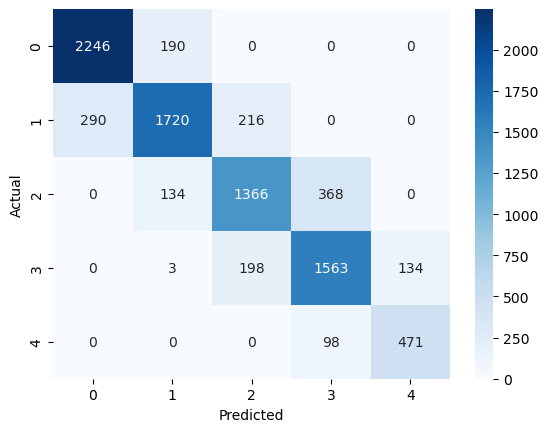

In [193]:
print('Confussion Matrix:')
sns.heatmap(confusion_matrix(y_clusters_test, clf_lgbm_preds), annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();

In [194]:
report = classification_report(y_clusters_test, clf_lgbm_preds)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2436
           1       0.84      0.77      0.81      2226
           2       0.77      0.73      0.75      1868
           3       0.77      0.82      0.80      1898
           4       0.78      0.83      0.80       569

    accuracy                           0.82      8997
   macro avg       0.81      0.82      0.81      8997
weighted avg       0.82      0.82      0.82      8997



In [207]:
from sklearn.ensemble import VotingClassifier

voting_clf_hard = VotingClassifier(
    estimators=[
        ('model_1', clf_logreg),
        ('model_2', clf_rf),
        ('model_3', clf_xgb),
        ('model_4', clf_lgbm),

    ],
    voting = 'hard'  # 'hard' = majority vote
)

voting_clf_hard.fit(X_clusters_train, y_clusters_train)
final_predictions_hard = voting_clf_hard.predict(X_clusters_test)

voting_clf_soft = VotingClassifier(
    estimators=[
        ('model_1', clf_logreg),
        ('model_2', clf_rf),
        ('model_3', clf_xgb),
        ('model_4', clf_lgbm),
    ],
    voting = 'soft'  # 'hard' = majority vote
)

voting_clf_soft.fit(X_clusters_train, y_clusters_train)
final_predictions_soft = voting_clf_soft.predict(X_clusters_test)


Confussion Matrix:


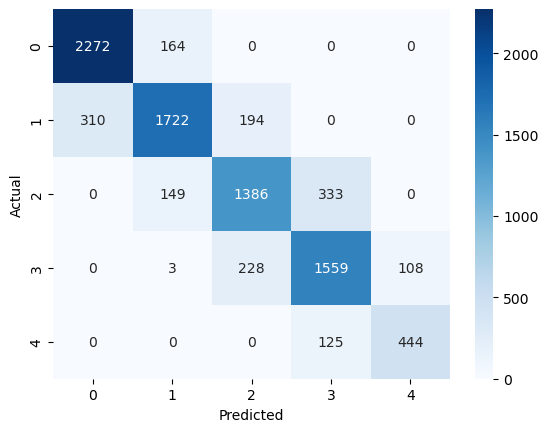

Confussion Matrix:


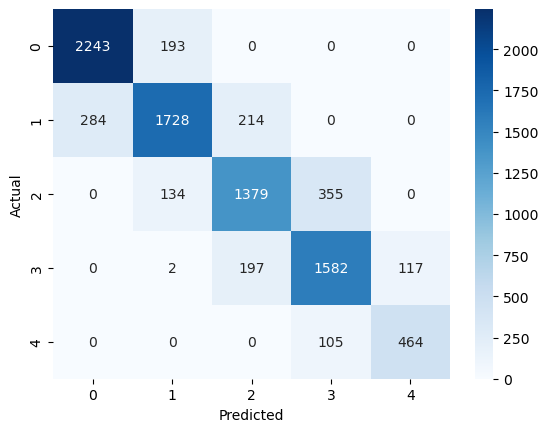

In [208]:
print('Confussion Matrix:')
sns.heatmap(confusion_matrix(y_clusters_test, final_predictions_hard), annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();

print('Confussion Matrix:')
sns.heatmap(confusion_matrix(y_clusters_test, final_predictions_soft), annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();

In [210]:
report = classification_report(y_clusters_test, final_predictions_hard)
print("Classification Report:")
print(report)

report = classification_report(y_clusters_test, final_predictions_soft)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      2436
           1       0.84      0.77      0.81      2226
           2       0.77      0.74      0.75      1868
           3       0.77      0.82      0.80      1898
           4       0.80      0.78      0.79       569

    accuracy                           0.82      8997
   macro avg       0.81      0.81      0.81      8997
weighted avg       0.82      0.82      0.82      8997

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2436
           1       0.84      0.78      0.81      2226
           2       0.77      0.74      0.75      1868
           3       0.77      0.83      0.80      1898
           4       0.80      0.82      0.81       569

    accuracy                           0.82      8997
   macro avg       0.81      0.82      0.81      8997
weighted avg       0.82      0.

In [211]:
accuracy_hard = voting_clf_hard.score(X_clusters_test, y_clusters_test)
print("Hard accuracy:", accuracy_hard)

accuracy_soft = voting_clf_soft.score(X_clusters_test, y_clusters_test)
print("Soft accuracy:", accuracy_soft)

Hard accuracy: 0.8206068689563187
Soft accuracy: 0.822051795042792


In [218]:
voting_soft_proba = voting_clf_soft.predict_proba(X_clusters_test)
auc_score = roc_auc_score(y_clusters_test, voting_soft_proba, multi_class = 'ovr')
print("Multi-class AUC (One-vs-Rest):", auc_score)

Multi-class AUC (One-vs-Rest): 0.9730740914780552
